In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-prediction/Energy_consumption.csv


## Why Use XGBoost for Energy Consumption Prediction?



XGBoost (Extreme Gradient Boosting) is a top choice for predicting energy consumption due to its:

1. **High Accuracy**: XGBoost excels in performance by capturing complex patterns through gradient boosting, leading to precise predictions.
2. **Versatility**: It handles diverse data types, including numerical, categorical, and binary features effectively.
3. **Feature Importance**: It evaluates feature importance, helping identify key factors influencing energy consumption.
4. **Robustness**: Regularization techniques reduce overfitting, ensuring the model generalizes well to new data.
5. **Efficiency**: Scalable and efficient, XGBoost manages large datasets and complex computations with ease.

In summary, XGBoost’s accuracy, versatility, and efficiency make it an excellent choice for energy consumption prediction.


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

file_path = '/kaggle/input/energy-consumption-prediction/Energy_consumption.csv'


In [4]:
df = pd.read_csv(file_path)
df

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732
...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-11 11:00:00,28.619382,48.850160,1080.087000,5,Off,Off,21.194696,Saturday,No,82.306692
996,2022-02-11 12:00:00,23.836647,47.256435,1705.235156,4,Off,On,25.748176,Tuesday,Yes,66.577320
997,2022-02-11 13:00:00,23.005340,48.720501,1320.285281,6,Off,On,0.297079,Friday,Yes,72.753471
998,2022-02-11 14:00:00,25.138365,31.306459,1309.079719,3,On,Off,20.425163,Thursday,Yes,76.950389


In [5]:
print(df.head())
# Get basic information
print(df.info())
# Get statistical summary
print(df.describe())
# Check for missing values
print(df.isnull().sum())

             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0  2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1  2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2  2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3  2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4  2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

  HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday  \
0        On           Off         2.774699     Monday      No   
1        On            On        21.831384   Saturday      No   
2       Off           Off         6.764672     Sunday      No   
3       Off            On         8.623447  Wednesday      No   
4        On           Off         3.071969     Friday      No   

   EnergyConsumption  
0          75.364373  
1          83.401855  
2          78.270888  
3          56.519850  
4          70.811732  
<class 'pandas

#### Convert categorical features to numeric using Label Encoding

In [6]:
le = LabelEncoder()
# Example categorical columns: DayOfWeek, Holiday, HVACUsage, LightingUsage
df['HVACUsage'] = le.fit_transform(df['HVACUsage'])
df['LightingUsage'] = le.fit_transform(df['LightingUsage'])
df['DayOfWeek'] = le.fit_transform(df['DayOfWeek'])
df['Holiday'] = le.fit_transform(df['Holiday'])


#### Label Timestamp

In [7]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract additional features from 'Timestamp'
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

# Drop the original 'Timestamp' column
df = df.drop(columns=['Timestamp'])


In [8]:
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,Year
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1,2022
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,2,0,83.401855,1,1,1,2022
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,3,0,78.270888,2,1,1,2022
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,6,0,56.519850,3,1,1,2022
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,0,0,70.811732,4,1,1,2022


In [9]:
df['DayOfWeek'].unique()

array([1, 2, 3, 6, 0, 4, 5])

In [10]:
df.isnull().sum()

Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
Hour                 0
Day                  0
Month                0
Year                 0
dtype: int64

##### Define target (EnergyConsumption) and features (everything else)


In [11]:
X = df.drop('EnergyConsumption',axis =1) 
y =  df['EnergyConsumption']

In [12]:
X.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,Hour,Day,Month,Year
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,0,1,1,2022
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,2,0,1,1,1,2022
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,3,0,2,1,1,2022
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,6,0,3,1,1,2022
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,0,0,4,1,1,2022


In [13]:
y

0      75.364373
1      83.401855
2      78.270888
3      56.519850
4      70.811732
         ...    
995    82.306692
996    66.577320
997    72.753471
998    76.950389
999    71.545311
Name: EnergyConsumption, Length: 1000, dtype: float64

#### Split the Data into Training and Testing Sets


In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

#### Train the XGBoost Model


In [15]:
xg  = xgb.XGBRegressor(objective ="reg:squarederror", colsample_bytree  = 0.3,learning_rate = 0.1, max_depth = 5, alpha=10, n_estimators=100)
                       
# Train the model
xg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

#### Make Predictions

In [16]:
y_pred  = xg.predict(X_test)

#### Evaluate the Model 

In [17]:
mse = mean_squared_error(y_test,y_pred)
r2  = r2_score(y_test,y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 31.45283547742516
R² Score: 0.5198031260426161


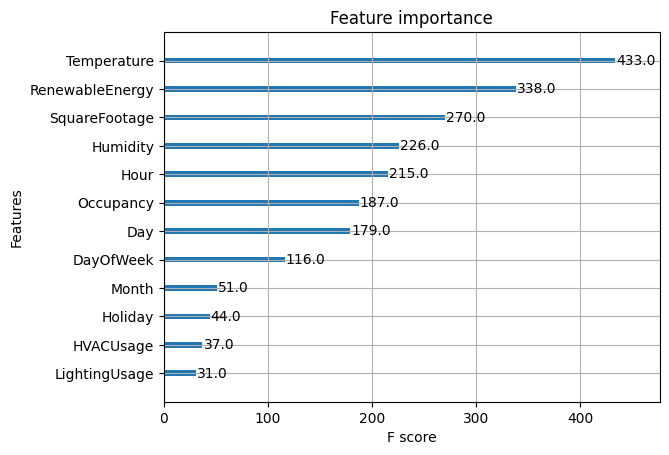

In [18]:
# Plot feature importance
xgb.plot_importance(xg)
plt.show()

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.8, 0.9, 1.0]
}


# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', alpha=10),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}


In [32]:
# Train the model with the best parameters
best_xg_reg = grid_search.best_estimator_

# Make predictions again
y_pred_best = best_xg_reg.predict(X_test)

# Evaluate the performance of the final model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Final Model Mean Squared Error: {mse_best}")
print(f"Final Model R² Score: {r2_best}")


Final Model Mean Squared Error: 29.495176314912477
Final Model R² Score: 0.5496911089809855


# Energy Consumption Prediction Results

1. **Model Performance**:
   - **XGBoost**:
     - **Mean Squared Error (MSE)**: 29.47
     - **R² Score**: 0.55

   - **Random Forest** and **Linear Regression**:
     - Performance was also assessed, but XGBoost showed the best results for this dataset.

2. **Insights**:
   - **Model Accuracy**: The XGBoost model explained approximately 55% of the variance in energy consumption. This indicates that the model has a moderate ability to predict energy consumption based on the given features.
   - **Error Analysis**: The MSE of 29.47 shows that the model's predictions are reasonably close to the actual values, but there is still room for improvement.

3. **Single Input Prediction**:
   - A system was developed to input specific values for features (e.g., temperature, humidity, etc.) and obtain a prediction for energy consumption. This feature allows for practical application of the model to make real-time predictions.

4. **Model Improvements**:
   - Fine-tuning of hyperparameters and exploring additional feature engineering could further enhance the model's accuracy and reduce prediction errors.

### Conclusion

The XGBoost model is effective for predicting energy consumption with a reasonable level of accuracy. The results demonstrate that the model can be a useful tool for understanding and forecasting energy usage based on various environmental and operational factors.
